In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

img_name = 'img/cameraman.tif'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)
hist = cv.calcHist([img], [0], None, [256], [0,256])
cdf = hist.ravel().cumsum()
cdf_normal = cdf / cdf[-1]
hist_normal = hist / cdf[-1]

Text(0.5, 1.0, 'cdf_normal')

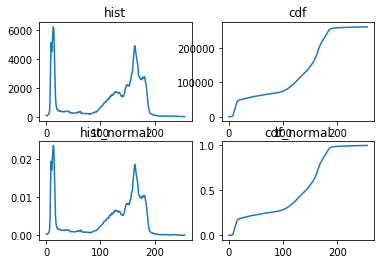

In [2]:
fig, ax_list = plt.subplots(2, 2)
ax_list[0][0].plot(hist)
ax_list[0][0].set_title('hist')
ax_list[0][1].plot(cdf)
ax_list[0][1].set_title('cdf')
ax_list[1][0].plot(hist_normal)
ax_list[1][0].set_title('hist_normal')
ax_list[1][1].plot(cdf_normal)
ax_list[1][1].set_title('cdf_normal')

In [3]:
def max_entropy(hist):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    参考：https://github.com/zenr/ippy/blob/master/segmentation/max_entropy.py
    Params:
        hist [np.array]: Sequence representing the histogram of the image
    Return:
        threshold [int]: threshold calculated by 最大熵分割算法
    """

    # calculate CDF (cumulative density function)
    cdf = hist.cumsum()
    cdf_normal = cdf / cdf[-1]
    hist_normal = hist / cdf[-1]

    valid_range = np.nonzero(hist_normal)[0]
    start, end = valid_range[0], valid_range[-1]

    max_ent, threshold = 0, 0
    total_range = hist_normal[hist_normal != 0]
    H_n = -np.sum(total_range * np.log(total_range))
    ents = []
    for s in range(start, end):
        P_s = cdf_normal[s]
        s_range = hist_normal[:s+1]
        s_range = s_range[s_range != 0]
        H_s = -np.sum(s_range * np.log(s_range))
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)

        # find max
        ents.append(total_ent)
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold, max_ent, start, end, ents

In [4]:
threshold, max_ent, ents_start, ents_end, ents = max_entropy(hist.ravel())

195


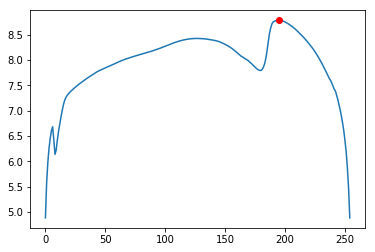

In [5]:
plt.plot(range(ents_start, ents_end), ents)
plt.plot(threshold, max_ent, 'ro')
print(threshold)

threshod calculated by 最大熵分割算法: 195


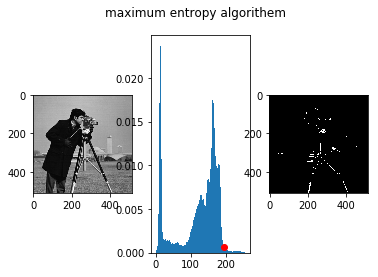

In [6]:
_, thr_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
fig, ax_list = plt.subplots(1, 3)
fig.suptitle('maximum entropy algorithem')
ax_list[0].imshow(img, 'gray')

ax_list[1].hist(img.ravel(), 256, [0,256], density=True)
ax_list[1].plot(threshold, hist_normal[threshold], 'ro')

ax_list[2].imshow(thr_img, 'gray')

print(f'threshod calculated by 最大熵分割算法: {threshold}')
plt.show()

In [7]:
max_entropy(np.array([0, 70, 2, 2, 2, 20, 2, 10, 50, 1, 1, 1, 1, 1, 1, 0]))

(8,
 3.1740919006071544,
 1,
 14,
 [1.5210945257071622,
  1.575887277218842,
  1.621846771174386,
  1.6592609560639828,
  1.7830725529163498,
  1.7594950641683893,
  1.6416391160251318,
  3.1740919006071544,
  3.021225818677206,
  2.8272088572264487,
  2.568330373774541,
  2.1913515956666316,
  1.526379090006989])

In [8]:
max_entropy(np.array([0, 50, 50, 50, 50, 50, 50, 50, 50, 1, 1, 1, 1, 1, 1, 0]))

(8,
 3.871201010907918,
 1,
 14,
 [2.028840697425483,
  2.5814156105239485,
  2.823454766909249,
  2.916089942115156,
  2.897733337541191,
  2.764610822370175,
  2.478384156372479,
  3.871201010907918,
  3.701132002655242,
  3.4901862453328234,
  3.2146476045322556,
  2.82127195413682,
  2.1401606419922357])